# Attention is all you need: Discovering the Transformer model

# Neural machine traslation using a Transformer model

In this notebook we will describe and demystify the relevant artifacts in the paper "Attention is all you need" (Vaswani, Ashish & Shazeer, Noam & Parmar, Niki & Uszkoreit, Jakob & Jones, Llion & Gomez, Aidan & Kaiser, Lukasz & Polosukhin, Illia. (2017)). This paper was a more advanced step in the use of the attention mechanism being the main basis for a model called Transformer. The most famous current models that are emerging in NLP tasks consist of dozens of transformers or some of their variants, for example, GPT-3 or BERT.

Attention is all you need: https://arxiv.org/pdf/1706.03762.pdf

We will describe the components of this model, analyze their operation and build a simple model that we will apply to a small-scale NMT problem (Neural Machine Translation). To read more about the problem that we will address and to know how the basic attention mechanism works, I recommend you to read my previous  post [ "A Guide on the Encoder-Decoder Model and the Attention Mechanism"](https://medium.com/better-programming/a-guide-on-the-encoder-decoder-model-and-the-attention-mechanism-401c836e2cdb) and check the [ repository](https://github.com/edumunozsala/NMT-encoder-decoder-Attention).

![Alt](images/transformer.jpg "title Picture by Vinson Tan from Pixabay")

## Why we need Transformer?

In sequence-to-sequence treatment problems such as the neural machine translation, the initial proposals were based on the use of RNNs in an encoder-decoder architecture. These architectures presented a great limitation when working with long sequences, their ability to retain information from the first elements was lost when new elements were incorporated into the sequence. In the encoder, the hidden state in every step is associated with a certain word in the input sentence, the more recent. Therefore, if the decoder only accesses the last hidden state of the decoder, it will lose relevant information about the first elements of the sequence. Then to deal with this limitation, a new concept were introduced **the attention mechanism**.

Instead of paying attention to the last state of the encoder as is usually done with the RNNs, in each step of the decoder we look at all the states of the encoder, being able to access information about all the elements of the input sequence. This is what attention does, it extracts information from the whole sequence, a weighted sum of all the past encoder states. This allows the decoder to assign greater weight or importance to a certain element of the input for each element of the output. Learning in every step to focus in the right element of the input to predict the next output element.

But this approach continues to have an important limitation, each sequence must be treated one at a time. Both the encoder and the decoder have to wait till the completion of t-1 steps to process at 't'th step. So when dealing with huge corpus **it is very time consuming and computationally inefficient**.

# Loading the libraries

Load and install, if necessary, the python libraries we will use along this notebook. We force to import Tensorflow version 2, if it is available.

In [1]:
import math
import os
import gc
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import drive

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Setting some parameters and hyperparameters for our model

In [3]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 80000 #40000
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.
MAX_LENGTH = 15

# Global parameters
root_folder='/content/drive'
data_folder_name='My Drive/datasets/eng_spa_translations'
checkpoint_folder = "My Drive/Projects/Transformer_NMT/ckpt/"
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))

# Both train and test set are in the root data directory
train_path = DATA_PATH


# The dataset and text processing

For this exercise we will use pairs of simple sentences, the source in English and target in Spanish, from the Tatoeba project where people contribute adding translations every day. This is the [link](http://www.manythings.org/anki/) to some traslations in different languages. There you can download the Spanish - English spa_eng.zip file, it contains 124457 pairs of sentences.

We use a list of **non breaking prefixes** to avoid the tokenizer to split or break words including that prefixes. Inm our example we do not want to remove some the dot for some well-konw words.You can find non breaking prefixes for many languages in the Kaggle website: 

https://www.kaggle.com/nltkdata/nonbreaking-prefixes/activity


The text sentences are almost clean, they are simple plain text, so we only need to remove dots that are not a end of sentence symbol and duplicated white spaces. 

The following functions will apply the cleaning mentioned previously:


In [4]:
def preprocess_text_nonbreaking(corpus, non_breaking_prefixes):
  corpus_cleaned = corpus
  # Add the string $$$ before the non breaking prefixes
  # To avoid remove dots from some words
  for prefix in non_breaking_prefixes:
    corpus_cleaned = corpus_cleaned.replace(prefix, prefix + '$$$')
  # Remove dots not at the end of a sentence
  corpus_cleaned = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_cleaned)
  # Remove the $$$ mark
  corpus_cleaned = re.sub(r"\.\$\$\$", '', corpus_cleaned)
  # Rmove multiple white spaces
  corpus_cleaned = re.sub(r"  +", " ", corpus_cleaned)

  return corpus_cleaned


## Loading the dataset

Mount our Google Drive unit to access the datafiles from the notebook

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


Loading the list of non breaking prefixes for the english and the spanish sentences

In [6]:
with open(DATA_PATH+"/nonbreaking_prefix.en", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_en = f.read()
with open(DATA_PATH+"/nonbreaking_prefix.es", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_es = f.read()

non_breaking_prefix_en = non_breaking_prefix_en.split("\n")
non_breaking_prefix_en = [' ' + pref + '.' for pref in non_breaking_prefix_en]
non_breaking_prefix_es = non_breaking_prefix_es.split("\n")
non_breaking_prefix_es = [' ' + pref + '.' for pref in non_breaking_prefix_es]

Load the dataset into a pandas dataframe and apply the preprocess function to the input and target columns.

In [7]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_en)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_es)).tolist()

print('Number of sentences: ',len(input_data))
print(input_data[:5])
print(target_data[:5])

Number of sentences:  80000
['Go.', 'Go.', 'Go.', 'Go.', 'Hi.']
['Ve.', 'Vete.', 'Vaya.', 'Váyase.', 'Hola.']


In [8]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

0

# Tokenize the text data

Next, let's see how to prepare the data for our model. It is very simple and the steps are the following:

- Create the vocabulary from the corpus using Subword tokenization, breaking words into “subword units” - strings of characters like ing or eau - that allow the downstream model to make intelligent decisions on words it doesn’t recognize.
- Calculate the maximum length of the input and output sequences.
- Tokenize the data, convert the raw text into a sequence of integers. Once we define the vocabulary, we use the encode method to get the token for every word in the corpus.
- Remove sentences longer that the max length defined.
- Padding the sentences: we need to pad zeros at the end of the sequences so that all sequences have the same length. Otherwise, we won't be able train the model on batches

In [9]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove


In [10]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(input_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(target_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)

In [11]:
# Check the tokenize function
print(encoder_inputs[:5], sos_token_input, eos_token_input)
print(decoder_outputs[:5], sos_token_output, eos_token_output)

[[14050  5483 13840 14051     0     0     0     0     0     0     0     0
      0     0     0]
 [14050  5483 13840 14051     0     0     0     0     0     0     0     0
      0     0     0]
 [14050  5483 13840 14051     0     0     0     0     0     0     0     0
      0     0     0]
 [14050  5483 13840 14051     0     0     0     0     0     0     0     0
      0     0     0]
 [14050  2180 13840 14051     0     0     0     0     0     0     0     0
      0     0     0]] [14050] [14051]
[[15568 10468 15358 15569     0     0     0     0     0     0     0     0
      0     0     0]
 [15568 10468   263 15358 15569     0     0     0     0     0     0     0
      0     0     0]
 [15568 10469 15358 15569     0     0     0     0     0     0     0     0
      0     0     0]
 [15568 14581 15358 15569     0     0     0     0     0     0     0     0
      0     0     0]
 [15568  2976 15358 15569     0     0     0     0     0     0     0     0
      0     0     0]] [15568] [15569]


In [12]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  14052
Size of Output Vocabulary:  15570


# Create the batch data generator

- Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function batch_on_slices on the input and output sequences.

In [13]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Building a Transformer

## What is Transformer?
*"In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization … the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution."*

"Attention is all you need" paper

The Transformer model extract  features for each word using a self-attention mechanism to figure out how important all the other words in the sentence are w.r.t. to the aforementioned word. And no recurrent units are used to obtain this features, they are just weighted sum and activations, so they can be very parallelizable and efficient.

But We will dive deeper to understand what all this means.

# Self-attention: the fundamental operation

*"Self-attention is a sequence-to-sequence operation: a sequence of vectors goes in, and a sequence of vectors comes out. Let's call the input vectors 𝐱1,𝐱2,…𝐱t and the corresponding output vectors 𝐲1,𝐲2,…,𝐲t. The vectors all have dimension k. To produce output vector 𝐲i, the self attention operation simply takes a weighted average over all the input vectors, the simplest option is the dot product."*

**Transformers from scratch by Peter Bloem**

In the self-attention mechanism of our model we need to introduce three elements: Queries, Values and Keys



## Queries, Keys and Values
Every input vector is used in three different ways in the self-attention mechanism: the Query, the Key and the Value. In every role, it is compared to the others vectors to get its own output yi (Query), to get the j-th output yj (Key) and to compute each output vector once the weights have been established (Value).

To obtain this roles, we need three weight matrices of dimensions k x k and compute three linear transformation for each xi:

![Alt](images/query_key_value.png "title "Transformers from scratch" by Peter Bloem")

These three matrices are usually known as K, Q and V, three learnable weight layers that are applied to the same encoded input. Consequently, as each of these three matrices come from the same input, we can apply the attention mechanism of the input vector with itself, a "self-attention".


## Scale dot-product Attention

*The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the query with all keys, divide each by the square root of dk, and apply a softmax function to obtain the weights on the values.*

"Attention is all you need" paper

Then we use the Q, K and V matrices to calculate the attention scores. **The scores measure how much focus to place on other places or words of the input sequence w.r.t a word at a certain position**. That is, the dot product of the query vector with the key vector of the respective word we're scoring. So, for position 1 we calculate the dot product (.) of q1 and k1, then q1 . k2, q1 . k3,… 

Next we apply the "scaled" factor to have more stable gradients. The softmax function can not work properly with large values, resulting in vanishing the gradient and slow down the learning. After "softmaxing" we multiply by the Value matrix to keep the values of the words we want to focus on and minimizing or removing the values for the irrelevant words (its value in V matrix should be very small).

The formula for these operations is:

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $


In [14]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

## Multi-Head Attention

In the previous description the attention scores are focused on the whole sentence at a time, this would produce the same results even if two sentences contain the same words in a different order. Instead, we would like to attend to different segments of the words. We can give the self attention greater power of discrimination, **by combining several self attention heads**, dividing the words vectors into a fixed number (h, number of heads) of chunks, and then self-attention is applied on the corresponding chunks, using Q, K and V sub-matrices. 

This produce h different output matrices of scores.

![Alt](images/dor_product_multihead.PNG "title From "Attention is all you need" paper by Vaswani, et al., 2017")

But the next layer (the Feed-Forward layer) is expecting just one matrix, a vector for each word, so after calculating the dot product of every head, we concat the output matrices and multiply them by an additional weights matrix $W_O$. This final matrix captures information from all the attention heads.

$MultihHead(Q, K, V ) = \text{Concat}(head_1,...,head_n)W^O$

where $head_i=Attention(QW_i^Q,QW_i^K,QW_i^V)$ and $i$ is the head index.


In [15]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

# Positional Encoding

We mentioned briefly that the order of the words in the sentence is an issue to solve in this model, because the network and the self-attention mechanism is permutation invariant. If we shuffle up the words in the input sentence, we get the same solutions. We need to create a representation of the position of the word in the sentence and add it to the word embedding.

*To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension as the embeddings, so that the two can be summed. There are many choices of positional encodings.*

"Attention is all you need" paper

So, we apply a function to map the position in the sentence to real valued vector. The network will learn how to use this information. Another approach would be to use a position embedding, similar to word embedding, coding every known position with a vector. It would requiere sentences of all accepted positions during training but positional encoding allow the model to extrapolate to sequence lengths longer than the ones encountered.

In the paper a sinusoidal function is applied:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [16]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

# The Encoder

Now that all the main pieces of the model have been described we can introduce the encoder components. 

- Positional encoding: Add the position encoding to the input embedding (our input words are transformed to embedding vectors). *"The same weight matrix is shared between the two embedding layers (encoder and decoder) and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by square root of the model dimension"* [1], ${\sqrt{d_{model}}}$.

- N = 6, identical layers, containing two sub-layers: a **multi-head self-attention mechanism**, and a **fully connected feed-forward network**. This FC layer is applied to each position separately and identically and consists of two linear transformations with a ReLU activation in between. But it is applied position-wise to the input, which means that the same neural network is applied to every single "token" vector belonging to the sentence sequence.

$$FFN(x)= max(0,xW_1+b_1)W_2+b_2$$

- There is a residual connection around each sub-layer (attention and FC network) followed by a layer normalization.

*Normalization and residual connections are standard tricks used to help deep neural networks train faster and more accurately. The layer normalization is applied over the embedding dimension only.*

**Peter Bloem, "Transformers from scratch"**

The next figure will show the components detailed:

![Alt](images/encoder.PNG "title "The Ilustrated Transformer" by Jay Alammar")

Keep in mind that **only the vector from the last layer (6-th) is sent to the decoder**.

In [17]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [18]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

# The Decoder

The decoder share some components with the encoder but they are used in a different way to take into account the encoder output.

- Positional encoding: Similar that the one in the encoder
- N=6 identical layers, containing 3 three sublayers. First, the Masked Multi-head attention or **masked causal attention** to prevent positions from attending to subsequent positions, hiding those features that belong to future states of the sequence. "This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i" [1]. It is implemented setting to −∞ the values corresponding to the forbidden states in the softmax layer of the dot-product attention modules. The second component or **"encoder-decoder attention"** performs multi-head attention over the output of the decoder, the Key and Value vectors come from the output of the encoder but the queries come from the previous decoder layer. *This allows every position in the decoder to attend over all positions in the input sequence* [1]. And finally the fully-connected network.

- The residual connection and layer normalization around each sub-layer, similar to the encoder.

![Alt](images/decoder.PNG "title "The Ilustrated Transformer" by Jay Alammar")

At the end of the N stacked decoders, the **linear layer**, a fully-connected network, transforms the stacked outputs to a much larger vector, the *logits*. The **softmax layer** then turns those scores (logits) into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.


In [19]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [20]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)

        return outputs

# Transformer

Once we have defined our components and created the encoder, the decoder and the linear-softmax final layer, we join the pieces to form our model, the Transformer.

![Alt](images/transformer_architecture.PNG "title "Attention is all you need" paper")

In [21]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

It is worth mentioning that we create 3 masks, each of which will allow us:
- *Encoder mask*: It is a padding mask to discard the pad tokens from the attention calculation.
- *Decoder mask 1*: this mask is a union of the padding mask and the look ahead mask which will help the causal attention to discard the tokens "in the future". We take the maximum value between the padding mask and the look ahead one.
- *Decoder mask 2*: it is the padding mask and is applied in the encoder-decoder attention layer.

As you can see then we call the encoder, the decoder and the final linear-softmax layer to get the predicted output from our Transformer model.

# Training the Transformer model
Now that we have described in detail the components in the paper we are ready to implement them and train a transformer model on a NMT problem. It is a toy problem for educational purposes.

We need to create a custom loss function to mask the padding tokens and we define the Adam optimizer described in the paper, with beta1 = 0.9, beta2 = 0.98 and epsilon= 10e-9. And then we create a scheduler to vary the learning rate over the training process according to:

$lrate = d_{model}^{-0.5}*min(step\_num^{-0.5}, step\_num*warmup\_steps^{-1.5})$


In [22]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


And that's all, we have all the necessary elements to train our model using an usual loop for sequence-to-sequence tasks:
- For every iteration on the batch generator that produce batch size inputs and outputs
- Get the input sequence from 0 to length-1 and the actual outputs from 1 to length, the next word expected at every sequence step.
- Call the transformer to get the predictions
- Calculate the loss function between the real outputs and the predictions
- Apply the gradients to update the weights in the model
- Calculate the mean loss and the accuracy for the batch data
- Show some results and save the model in every epoch

In [23]:
def main_train(dataset, transformer, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = transformer(enc_inputs, dec_inputs, True)
            # Calculate the loss
            loss = loss_function(dec_outputs_real, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    # Checkpoint the model on every epoch        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

Setting the hyperparameters and parameters of the model and training process:

In [24]:
# Set hyperparamters for the model
D_MODEL = 512 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1


Now we define and create all the elements to train the model and evaluate it.

In [25]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

It is very useful to checkpoint and save our model during training. Training can take a lot of time and we can restore the model for future training or use.

In [26]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [27]:
# Train the model
losses, accuracies = main_train(dataset, transformer, EPOCHS, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 4.7359 Accuracy 0.0000
Epoch 1 Batch 100 Loss 4.6680 Accuracy 0.0530
Epoch 1 Batch 200 Loss 4.3400 Accuracy 0.0824
Epoch 1 Batch 300 Loss 3.9776 Accuracy 0.1032
Epoch 1 Batch 400 Loss 3.6847 Accuracy 0.1182
Epoch 1 Batch 500 Loss 3.4673 Accuracy 0.1302
Epoch 1 Batch 600 Loss 3.2969 Accuracy 0.1401
Epoch 1 Batch 700 Loss 3.1606 Accuracy 0.1487
Epoch 1 Batch 800 Loss 3.0452 Accuracy 0.1566
Epoch 1 Batch 900 Loss 2.9457 Accuracy 0.1637
Epoch 1 Batch 1000 Loss 2.8575 Accuracy 0.1702
Epoch 1 Batch 1100 Loss 2.7813 Accuracy 0.1757
Epoch 1 Batch 1200 Loss 2.7106 Accuracy 0.1810
Saving checkpoint for epoch 1 in /content/drive/My Drive/Projects/Transformer_NMT/ckpt/ckpt-1
Time for 1 epoch: 508.13360619544983 secs

Starting epoch 2
Epoch 2 Batch 0 Loss 1.8356 Accuracy 0.2533
Epoch 2 Batch 100 Loss 1.8220 Accuracy 0.2488
Epoch 2 Batch 200 Loss 1.7898 Accuracy 0.2517
Epoch 2 Batch 300 Loss 1.7732 Accuracy 0.2539
Epoch 2 Batch 400 Loss 1.7554 Accuracy 0.2555
Ep

## Show some results from training

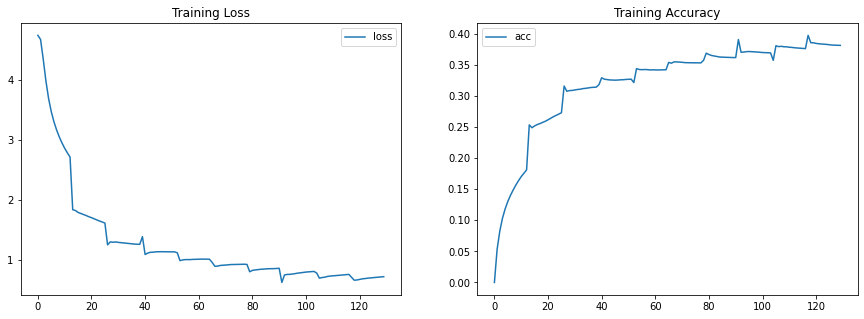

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

# Make predictions

We have seen the scores obtained after training but what we are interested in making predictions and see how the model works with new sentences. The predict function will input a tokenize sentence to the model and return the predicted new sentence, in our example, a translation from english to spanish. 
- Tokenize the input sentence to a sequence of tokens
- Set the initial output sequence to the SOS token
- Until we reach the max length or the eos token is returned by the model
- Get the next word predicted. The model returns the logits, remember that the softmax function is applied in the loss calculation.
- Get the index in the vocabulary of the word with the highest probability
- Concat the next word predicted to the output sequence

In [29]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

And finally our last function receives a sentence in english, calls the transformer to translate it to spanish and shows the result

In [30]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

First, we explore the predictions on sentences of our training dataset:

In [31]:
#Show some translations
sentence = "you should pay for it."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: you should pay for it.
Output sentence: Deberías pagarlo.


In [32]:
#Show some translations
sentence = "we have no extra money."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: we have no extra money.
Output sentence: No tenemos dinero extra.


Next, let's predict some new sentences on diferent topics:

In [33]:
#Show some translations
sentence = "This is a problem to deal with."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: This is a problem to deal with.
Output sentence: Este problema es un problema con eso.


In [34]:
#Show some translations
sentence = "This is a really powerful method!"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: This is a really powerful method!
Output sentence: ¡Esto es un verdadero poderoso!


In [35]:
#Show some translations
sentence = "This is an interesting course about Natural Language Processing"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: This is an interesting course about Natural Language Processing
Output sentence: Esta es una buena persona en la diez.
